In [2]:
import torch

In [4]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bash: ../xvfb: No such file or directory


Observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Action space: Discrete(3)


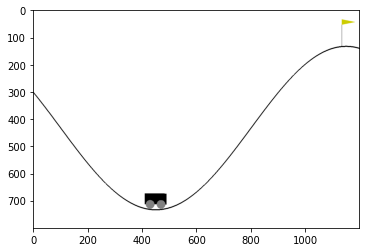

In [280]:
import gym

env = gym.make("MountainCar-v0")
env.reset()

plt.imshow(env.render('rgb_array'))
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

In [281]:
obs0 = env.reset()
print("initial observation code:", obs0)

initial observation code: [-0.43842474  0.        ]


In [282]:
print("taking action 2 (right)")
new_obs, reward, is_done, _ = env.step(2)

print("new observation code:", new_obs)
print("reward:", reward)
print("is game over?:", is_done)

taking action 2 (right)
new observation code: [-4.3805662e-01  3.6812358e-04]
reward: -1.0
is game over?: False


In [283]:
for i in range(100):
    new_obs, reward, is_done, _ = env.step(2)

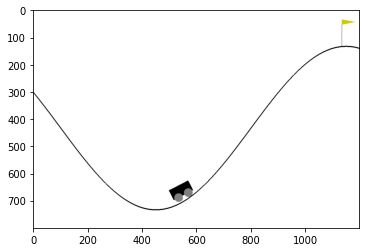

In [284]:
plt.imshow(env.render('rgb_array'))

In [285]:
from IPython import display

# Create env manually to set time limit. Please don't change this.
TIME_LIMIT = 250
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)
actions = {'left': 0, 'stop': 1, 'right': 2}

In [286]:
def policy(obs, t):
    # Write the code for your policy here. You can use the observation
    # (a tuple of position and velocity), the current time step, or both,
    # if you want.
    position, velocity = obs
    
    # This is an example policy. You can try running it, but it will not work.
    # Your goal is to fix that. You don't need anything sophisticated here,
    # and you can hard-code any policy that seems to work.
    # Hint: think how you would make a swing go farther and faster.
    if velocity > 0.02:
        return actions['right']
    else:
        return actions['left']

In [289]:
env.close()

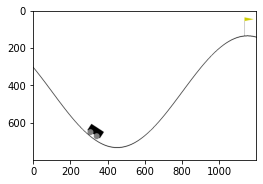

In [290]:
plt.figure(figsize=(4, 3))
display.clear_output(wait=True)

obs = env.reset()
for t in range(50):
    plt.gca().clear()
    
    action = policy(obs, t)  # Call your policy
    obs, reward, done, _ = env.step(action)  # Pass the action chosen by the policy to the environment
    
    # We don't do anything with reward here because MountainCar is a very simple environment,
    # and reward is a constant -1. Therefore, your goal is to end the episode as quickly as possible.

    # Draw game image on display.
    plt.imshow(env.render('rgb_array'))
    
    display.display(plt.gcf())
    display.clear_output(wait=True)

    if done:
        print("Well done!")
        break
else:
    print("Time limit exceeded. Try again.")

display.clear_output()

In [291]:
import gym
import numpy as np

env = gym.make("Taxi-v3")
env.reset()
env.render()

n_states = env.observation_space.n
n_actions = env.action_space.n

print("n_states=%i, n_actions=%i" % (n_states, n_actions))

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

n_states=500, n_actions=6


In [292]:
def initialize_policy(n_states, n_actions):
    policy = np.ones((n_states, n_actions)) / n_actions
    
    return policy

policy = initialize_policy(n_states, n_actions)

assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

In [359]:
env.reset()
env.render()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



/var/folders/5w/gytwm8sd6vldh9ym3dvj_x_m0000gn/T/ipykernel_74769/1148265676.py:33: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert type(r) in [float, np.float]


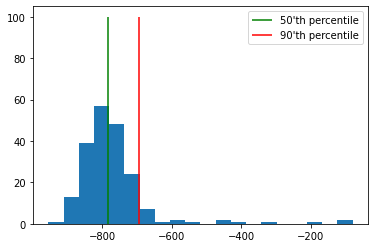

In [293]:
def generate_session(env, policy, t_max=10**4):
    """
    Play game until end or for t_max ticks.
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s = env.reset()

    for t in range(t_max):
        # Hint: you can use np.random.choice for sampling action
        # https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html
        a = np.random.choice(n_actions, p = policy[s])

        new_s, r, done, info = env.step(a)

        # Record information we just got from the environment.
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if done:
            break

    return states, actions, total_reward

s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) in [float, np.float]

# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [296]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]

    If you are confused, see examples below. Please don't assume that states are integers
    (they will become different later).
    """

    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = [s for state, reward in zip(states_batch, rewards_batch) if reward >= reward_threshold for s in state]
    elite_actions =  [a for action, reward in zip(actions_batch, rewards_batch) if reward >= reward_threshold for a in action]

    return elite_states, elite_actions

In [297]:
states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]), \
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]), \
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]), \
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]), \
    "Please make sure you use >=, not >. Also double-check how you compute percentile."

print("Ok!")

Ok!


In [298]:
def get_new_policy(elite_states, elite_actions):
    """
    Given a list of elite states/actions from select_elites,
    return a new policy where each action probability is proportional to

        policy[s_i,a_i] ~ #[occurrences of s_i and a_i in elite states/actions]

    Don't forget to normalize the policy to get valid probabilities and handle the 0/0 case.
    For states that you never visited, use a uniform distribution (1/n_actions for all states).

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    for s, a in zip(elite_states, elite_actions):
        new_policy[s,a] +=1
    new_policy[new_policy.sum(axis=1) ==0] = 1
    new_policy /= new_policy.sum(axis=1, keepdims=True)
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    return new_policy

In [300]:
elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = get_new_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(), \
    "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(new_policy >= 0), \
    "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(axis=-1), 1), \
    "Your new policy should be a valid probability distribution over actions"

reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)

print("Ok!")

Ok!


In [384]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
#     print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
#     plt.show()



In [415]:
def run_simulation(axis, n_sessions = 250, percentile = 50, learning_rate = 0.5):    
    
    policy = initialize_policy(n_states, n_actions)
    log = []
    rewards_batch = []
    reward_range=[-990, +10]

    for i in range(100):
        sessions = [ generate_session(env, policy) for _ in range(n_sessions)]

        states_batch, actions_batch, rewards_batch = zip(*sessions)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)

        new_policy = get_new_policy(elite_states, elite_actions)

        policy = learning_rate * new_policy + (1 - learning_rate) * policy

        # display results on chart
        show_progress(rewards_batch, log, percentile)

#     plt.figure(figsize=[8, 4])
#     plt.subplot(1, 2, 1)
    axis.plot(list(zip(*log))[0], label='Mean rewards')
    axis.plot(list(zip(*log))[1], label='Reward thresholds')
    axis.legend()
    axis.grid()
    axis.set_title(f"n_sessions: {n_sessions}, percentile: {percentile},\nlast reward: {log[-1][0]}")

#     plt.subplot(1, 2, 2)
#     plt.hist(rewards_batch, range=reward_range)
#     plt.vlines([np.percentile(rewards_batch, percentile)],
#                [0], [100], label="percentile", color='red')
#     plt.legend()
#     plt.grid()
#     clear_output(True)
#     print(f"n_sessions: {n_sessions}, percentile: {percentile}, last reward: {log[-1][0]}")
#     plt.show()

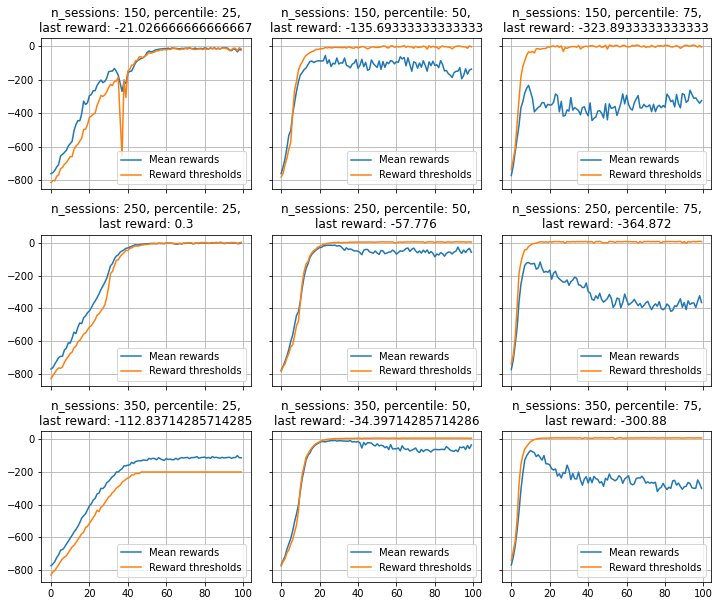

In [435]:
fig = plt.figure(figsize=[12, 10])
gs = fig.add_gridspec(3, 3, hspace=.3, wspace=.1)
axes = gs.subplots(sharex='col', sharey='row')
n_sessions_candidates = [150, 250, 350]
percentile_candidates = [25, 50, 75]

for i, n_sessions in enumerate(n_sessions_candidates):
    for j, percentile in enumerate(percentile_candidates):
        run_simulation(axes[i, j], n_sessions=n_sessions, percentile=percentile)

In [619]:
run_simulation(n_sessions=400, percentile = 20)

TypeError: run_simulation() missing 1 required positional argument: 'axis'

In [322]:
import time
obs = env.reset()

for t in range(50):
    
    env.render()
    action = np.random.choice(n_actions, p = policy[obs])  # Call your policy
    obs, reward, done, info = env.step(action)  # Pass the action chosen by the policy to the environment

    time.sleep(0.1)
    display.clear_output(wait=True)
    if done:
        print("OK")
        break
else:
    print("Not OK")


Not OK


In [599]:
class CEM:
    def __init__(self, environment:str="Taxi-v3"):
        self.env = gym.make(environment)
        self.n_states = self.env.observation_space.n
        self.n_actions = self.env.action_space.n
        self.policy = None
        
    def initialize_policy(self):
        self.policy = np.ones((self.n_states, self.n_actions)) / self.n_actions
        
    def generate_session(self, t_max=1000):
        states, actions = [], []
        total_reward = 0.
        state = self.env.reset()

        for t in range(t_max):
            action = np.random.choice(self.n_actions, p = self.policy[state])
            
            states.append(state)
            actions.append(action)
            
            state, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        
        return states, actions, total_reward
                
    def select_elites(self, states_batch, actions_batch, rewards_batch, percentile):

        reward_threshold = np.percentile(rewards_batch, percentile)

        elite_states = [s for state, reward in zip(states_batch, rewards_batch) if reward >= reward_threshold for s in state]
        elite_actions =  [a for action, reward in zip(actions_batch, rewards_batch) if reward >= reward_threshold for a in action]

        return elite_states, elite_actions
    
    def get_new_policy(self, elite_states, elite_actions):

        new_policy = np.zeros([self.n_states, self.n_actions])

        for s, a in zip(elite_states, elite_actions):
            new_policy[s,a] += 1
        new_policy[new_policy.sum(axis=1) ==0] = 1
        new_policy /= new_policy.sum(axis=1, keepdims=True)

        return new_policy
    
    def update_policy(self, total_states, learning_rate, top_n = 5):
        for state_id, states in enumerate(total_states):
            if len(states) == 0:
                continue
            
            states = sorted(states, key=lambda pair: pair[1])[-top_n:]
            total_states[state_id] = states
            
            new_policy = np.zeros(self.n_actions)
            for action, reward in states:
                new_policy[action] += 1
                
            new_policy /= new_policy.sum()
            self.policy[state_id] = learning_rate * new_policy + (1-learning_rate) * self.policy[state_id]

    def run_simulation(self, n_sessions = 250, percentile = 50, learning_rate = 0.5, steps = 100):    

        self.initialize_policy()
        log = []
        reward_range=[-990, +10]
        total_states = [[] for _ in range(self.n_states)]

        for step in range(steps):
            rewards_batch = []
            
            for i in range(n_sessions):
                states, actions, total_reward = self.generate_session()
                rewards_batch.append(total_reward)
                
                for state, action in zip(states, actions):
                    total_states[state].append((action, total_reward))

            self.update_policy(total_states, learning_rate)      
            
            mean_reward = np.mean(rewards_batch)
            threshold = np.percentile(rewards_batch, percentile)
            log.append([mean_reward, threshold])
            
        return log

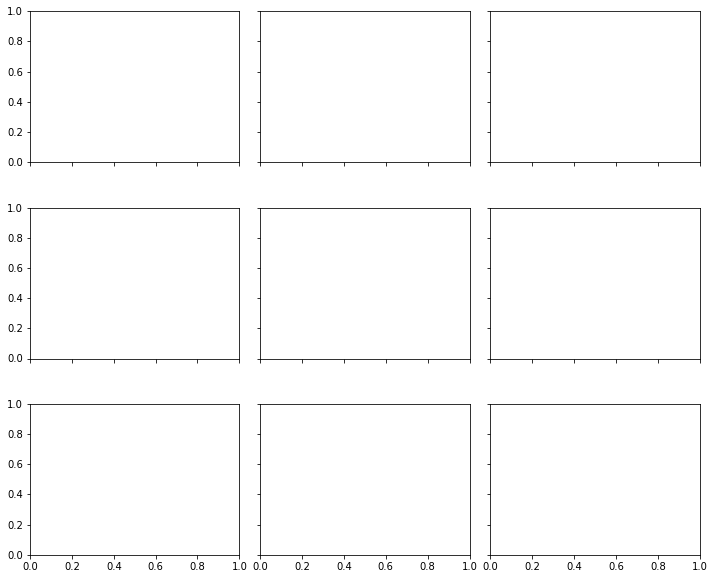

In [556]:
fig = plt.figure(figsize=[12, 10])
gs = fig.add_gridspec(3, 3, hspace=.3, wspace=.1)
axes = gs.subplots(sharex='col', sharey='row')

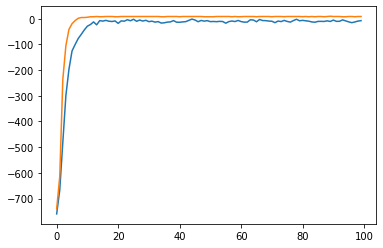

In [620]:
cem = CEM()
log = cem.run_simulation(n_sessions=200, percentile=75, steps=100)
plt.plot(list(zip(*log))[0], label='Mean rewards')
plt.plot(list(zip(*log))[1], label='Reward thresholds')

In [618]:
import time

policy = cem.policy
ok = 0
not_ok =0
for i in range(20):
    obs = env.reset()
    for t in range(150):

        env.render()
        action = np.random.choice(n_actions, p = policy[obs])  # Call your policy
        obs, reward, done, info = env.step(action)  # Pass the action chosen by the policy to the environment

        time.sleep(0.05)
        display.clear_output(wait=True)
        if done:
            ok += 1
            break
    else:
        not_ok += 1
    time.sleep(0.3)
        
print(f"ok: {ok}, not_ok: {not_ok}")

ok: 20, not_ok: 0
